In [2]:
from pathlib import Path
import re

# Given the input directory, this function loads all PDOS files from an elk calculation, 
# https://elk.sourceforge.net, and returns fulldos, a large multidimensional 
# dict of dict of lists of lists of lists:
#   fulldos[s][a][lms][row][col]
# Where:
# - s is the species number (typically 1,2,...)
# - a is the atom number (typically 1,2,...)
# - lms runs over all the input blocks within the file (how many and order depends on dosmsum and dossum settings)
# - row goes from 0...len(single block)-1
# - col is 0 (E-Efermi) or 1 (the PDOS for this s,a,lms,and E-Efermi)
#
# We use regular expressions to extract the species and atom numbers from the filenames,
# and regular expressions to parse the scientific notation E-Efermi,PDOS pairs
#
def load_pdos(srcDir):
    p = Path(srcDir)
    fulldos = {}
    for x in p.glob("PDOS*.OUT"):
        m = re.match("PDOS_S([0-9]+)_A([0-9]+).OUT", str(x))
        s = int(m.group(1))
        a = int(m.group(2))
        if not (s in fulldos):
            fulldos[s] = {}
        fulldos[s][a] = []
        with open(x, "r") as f:
            block = []
            for l in f.readlines():
                m = re.match("\s*([-0-9E\.]+)\s*([-0-9E\.]+)", l)
                if m is None:
                    # start of a new block
                    fulldos[s][a].append(block)
                    block = []
                else:
                    block.append([float(m.group(1)),float(m.group(2))])
    return fulldos

In [43]:
import logging
import numpy

# This code block implements several different variations of summing over components of the PDOS. 

def sum_atoms(fulldos):
    # sum over all atoms of a species, keeping the (lms) projections
    # implemented without numpy, which sacrifices speed for greater levels of
    # sanity check
    sdos = {}
    for s in fulldos:
        sdos[s] = []
        for lms in range(0,len(fulldos[s][1])):
            sdos[s].append([])
            for i in range(0,len(fulldos[s][1][lms])):
                x = fulldos[s][1][lms][i][0]
                y = 0.0
                for a in fulldos[s]:
                    if x != fulldos[s][a][lms][i][0]:
                        # this shouldn't happen
                        logging.warning("inconsistent x points found!")
                    else:
                        # partial sum
                        y = y + fulldos[s][a][lms][i][1]
                sdos[s][lms].append([x,y])
    return sdos

def sum_atoms_np(fulldos):
    # sum over all atoms of a species, keeping the (lms) projections
    # implemented via numpy, faster, but less sanity checking.
    sdos = {}
    for s in fulldos:
        sdos[s] = numpy.array(list(fulldos[s].values()))
        nat = sdos[s].shape[0]
        sdos[s] = sdos[s].sum(axis=0)
        sdos[s][:,:,0] /= nat
    return sdos

def sum_atoms_lms(fulldos, single_spin=False):
    # sum over all atoms and lms of a species
    # implemented without numpy, which sacrifices speed for greater levels of
    # sanity checking
    qdos = {}
    for s in fulldos:
        qdos[s] = []
        for i in range(0,len(fulldos[s][1][0])):
            x = fulldos[s][1][0][i][0]
            y = 0.0
            for lms in range(0,len(fulldos[s][1])):
                for a in fulldos[s]:
                    if x != fulldos[s][a][lms][i][0]:
                        # this shouldn't happen
                        logging.warning("inconsistent x points found!")
                    else:
                        # partial sum
                        if lms < len(fulldos[s][1])/2 or single_spin:
                            y = y + fulldos[s][a][lms][i][1]
                        else:
                            y = y - fulldos[s][a][lms][i][1]
            qdos[s].append([x,y])
    return qdos

def sum_atoms_lms_np(fulldos, single_spin=False):
    # sum over all atoms and lms of a species
    # implemented via numpy, faster, but less sanity checking.
    qdos = {}
    for s in fulldos:
        qdos[s] = numpy.array(list(fulldos[s].values()))
        natlms = qdos[s].shape[0]*qdos[s].shape[1]
        qdos[s] = qdos[s].sum(axis=0)
        if single_spin:
            qdos[s] = qdos[s].sum(axis=0)
        else:
            sa = numpy.split(qdos[s],2,axis=0)
            sa[1][:,:,0] *= -1.0
            qdos[s] = sa[0].sum(axis=0) - sa[1].sum(axis=0)
        qdos[s][:,0] /= natlms
    return qdos

def sum_species_atoms(fulldos):
    # sum over all species and atoms, leaving indexes by lms
    # implemented without numpy, which sacrifices speed for greater levels of
    # sanity checking
    rdos = []
    for lms in range(0,len(fulldos[1][1])):
        rdos.append([])
        for i in range(0,len(fulldos[1][1][lms])):
            x = fulldos[1][1][lms][i][0]
            y = 0.0
            for s in fulldos:
                for a in fulldos[s]:
                    if x != fulldos[s][a][lms][i][0]:
                        # this shouldn't happen
                        logging.warning("inconsistent x points found!")
                    else:
                        # partial sum
                        y = y + fulldos[s][a][lms][i][1]
            rdos[lms].append([x,y])
    return rdos

def sum_species_atoms_np(fulldos):
    # sum over all species and atoms, leaving indexes by lms
    # implemented via numpy, faster, but less sanity checking.
    sdos = sum_atoms_np(fulldos)
    rdos = numpy.zeros(sdos[1].shape)
    for s in sdos:
        rdos += sdos[s]
    rdos[:,:,0] /= len(sdos)
    return rdos

In [44]:
# Compute one example of each
pdos = load_pdos(".")
sdos = sum_atoms(pdos)
sdos_np = sum_atoms_np(pdos)
qdos = sum_atoms_lms(pdos)
qdos_np = sum_atoms_lms_np(pdos)
rdos = sum_species_atoms(pdos)
rdos_np = sum_species_atoms_np(pdos)

<IPython.core.display.Javascript object>


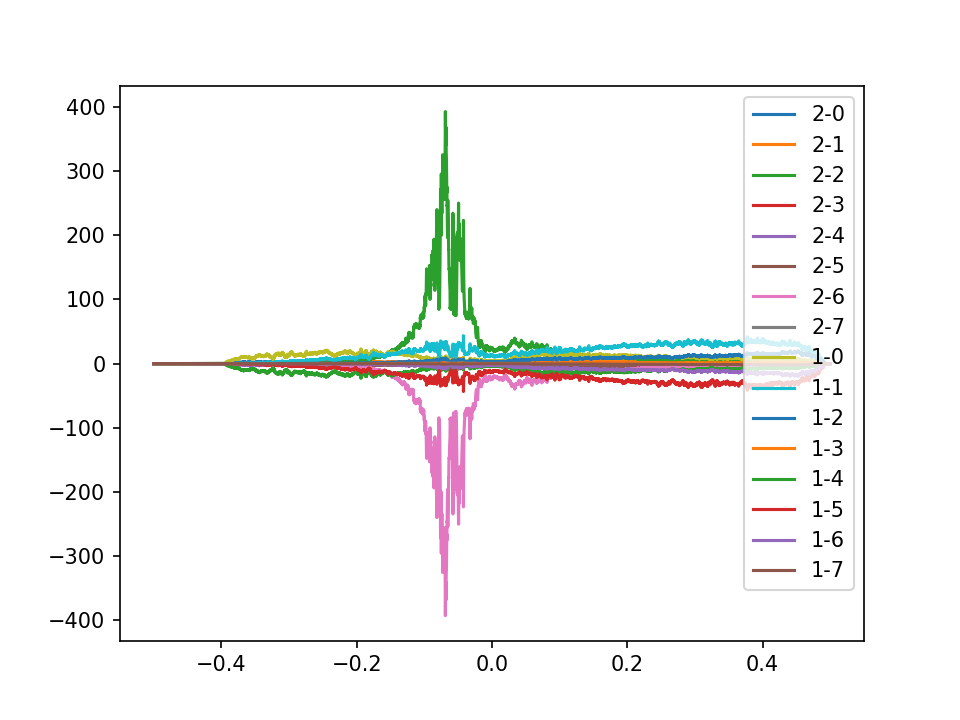

<IPython.core.display.Javascript object>


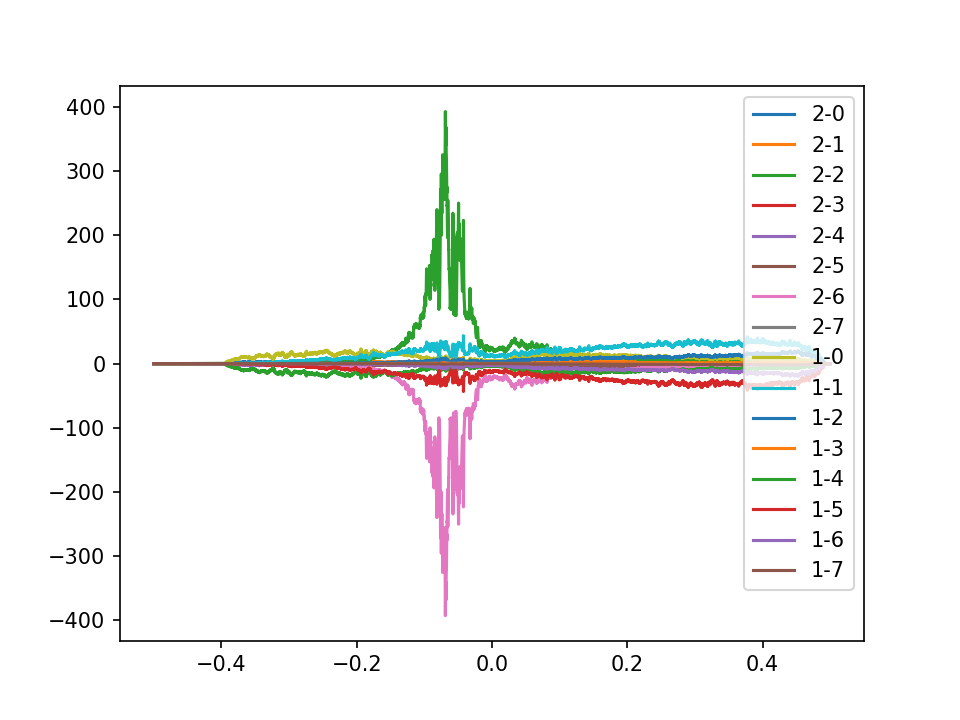

In [45]:
# Plot PDOS summed over all atoms of each species
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for s in sdos:
    for lms in range(0,len(sdos[s])):
        cols = [list(x) for x in zip(*sdos[s][lms])] # index by col,row
        plt.plot(cols[0],cols[1],label=str(s)+"-"+str(lms))
plt.legend()
plt.figure()
for s in sdos_np:
    for lms in range(0,len(sdos_np[s])):
        cols = sdos_np[s][lms].swapaxes(0,1) # index by col,row
        plt.plot(cols[0],cols[1],label=str(s)+"-"+str(lms))
plt.legend()


<IPython.core.display.Javascript object>


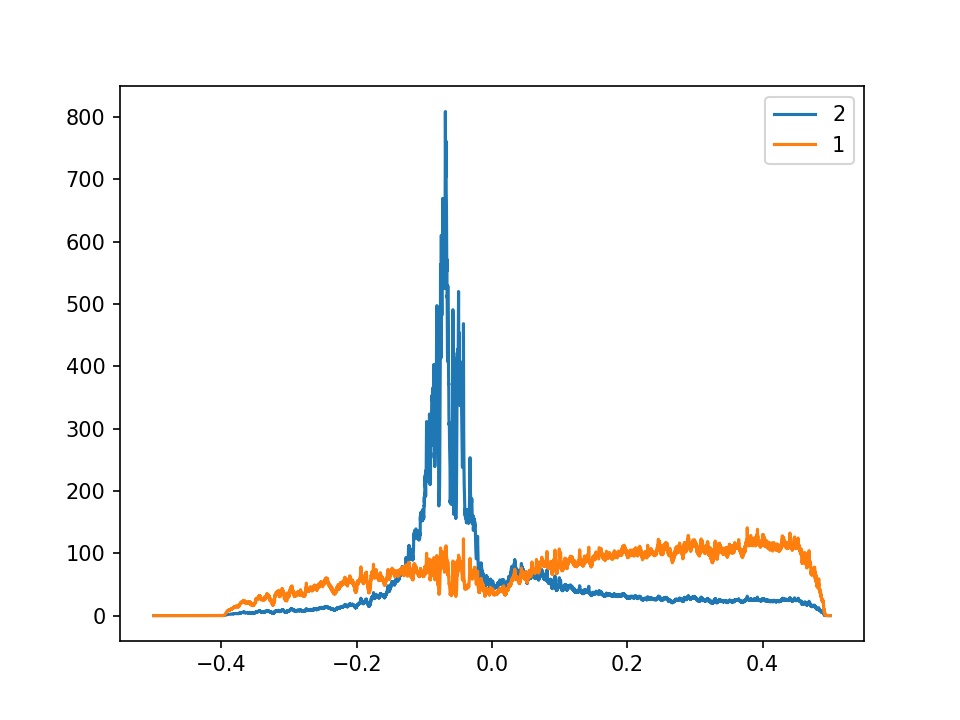

<IPython.core.display.Javascript object>


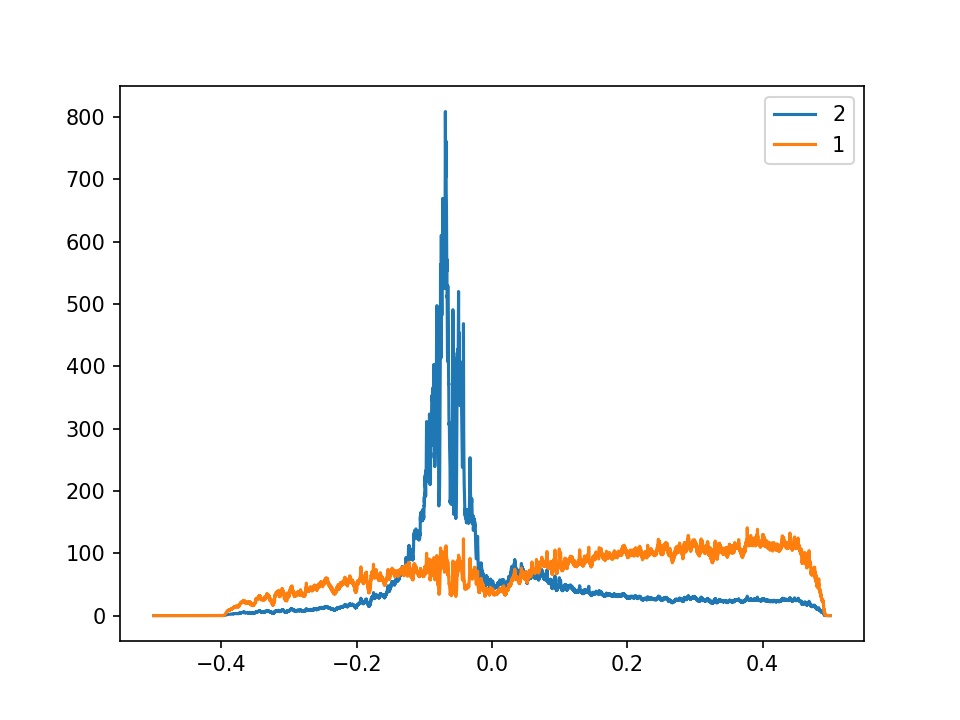

In [46]:
# Plot PDOS summed over all atoms and lms of each species
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for s in qdos:
    cols = [list(x) for x in zip(*qdos[s])] # index by col,row
    plt.plot(cols[0],cols[1],label=str(s))
plt.legend()
plt.figure()
for s in qdos_np:
    cols = qdos_np[s].swapaxes(0,1) # index by col,row
    plt.plot(cols[0],cols[1],label=str(s))
plt.legend()


<IPython.core.display.Javascript object>


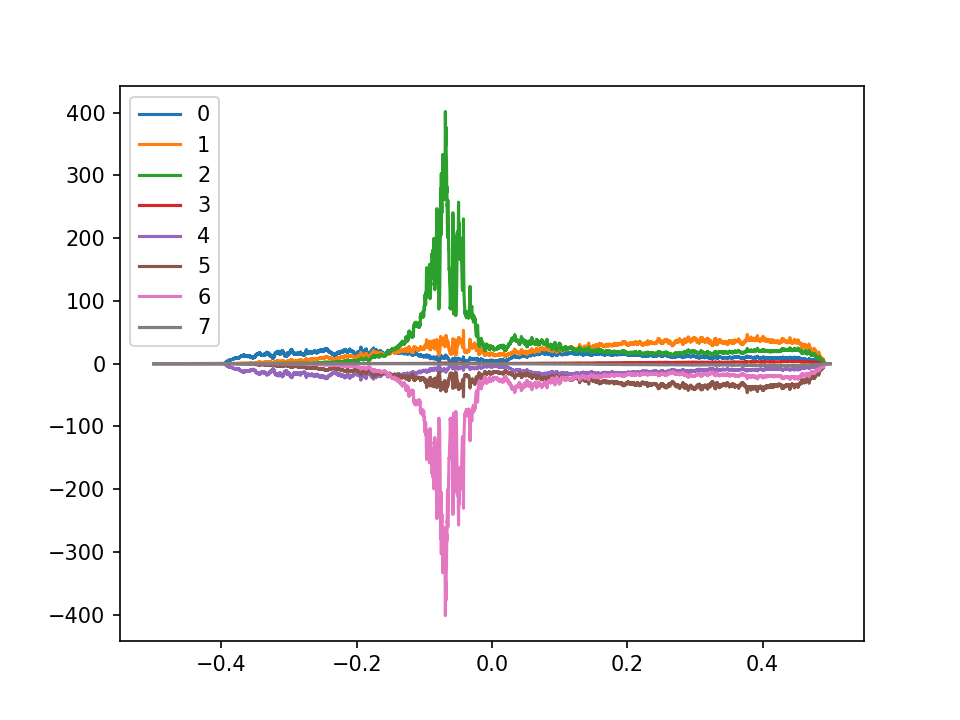

<IPython.core.display.Javascript object>


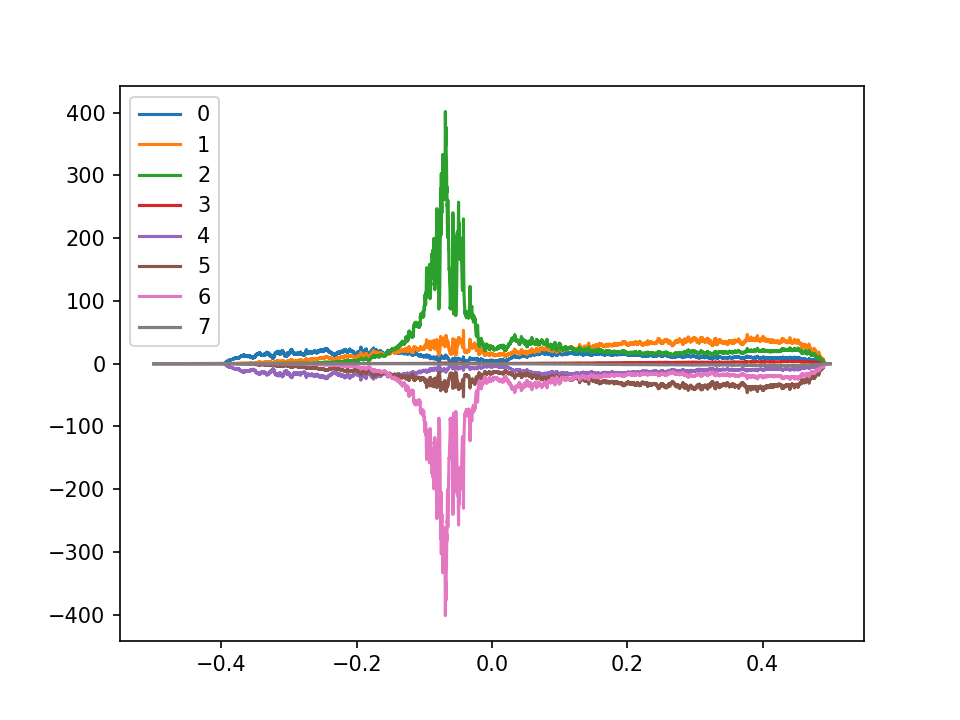

In [47]:
# Plot PDOS by lms summed over all atoms and species
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for lms in range(0,len(rdos)):
    cols = [list(x) for x in zip(*rdos[lms])] # index by col,row
    plt.plot(cols[0],cols[1],label=str(lms))
plt.legend()
plt.figure()
for lms in range(0,len(rdos_np)):
    cols = rdos_np[lms].swapaxes(0,1) # index by col,row
    plt.plot(cols[0],cols[1],label=str(lms))
plt.legend()


In [49]:
# examples of writing some of the results to a file.
#
# here we write sdos's to files, one per species, in the same block
# format as the input files
for s in sdos:
    with open("SDOS" + str(s) + ".OUT", "w") as f:
        for lms in range(0,len(sdos[s])):
            for i in range(0,len(sdos[s][lms])):
                f.write(str(sdos[s][lms][i][0]) + "    " + str(sdos[s][lms][i][1]) + "\n")
            f.write("\n")
# here we write sdos's to files, one per species, with a unified
# x column and different blocks as successive y columns,
# using CSV format.
for s in sdos:
    with open("SDOS" + str(s) + "_UNIFIED.OUT", "w") as f:
        for i in range(0,len(sdos[s][0])):
            x = sdos[s][0][i][0]
            f.write(str(x))
            for lms in range(0,len(sdos[s])):
                if sdos[s][lms][i][0] != x:
                    logging.warning("inconsistent x values found!")
                f.write(", " + str(sdos[s][lms][i][1]))
            f.write("\n")
